<a href="https://colab.research.google.com/github/GretaDanesi18/Olive_Detection_Tracking/blob/main/YOLOv5_olive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **SETUP**

Per prima cosa cloniamo la repo contente YOLOv5 e installiamo i requisiti

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

Successivamente importiamo le librerie necessarie

In [ ]:
import torch 
import os
import random 
import shutil
import glob
from IPython.display import Image,display
from PIL import Image, ImageDraw
import cv2
import pandas as pd
import subprocess
from numpy import source


Controlliamo l'utilizzo del device GPU oppure CPU

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.11.0+cu102  Device: cuda


## **CREAZIONE DATASET SOURCE DETECTOR**

Cloniamo la repo contente il dataset iniziale, i frame dei video e il file yaml

In [ ]:
!git clone https://github.com/GretaDanesi18/Olive_Detection_Tracking.git

Cloning into 'Olive_Detection_Tracking'...
remote: Enumerating objects: 2937, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 2937 (delta 9), reused 16 (delta 4), pack-reused 2912
Receiving objects: 100% (2937/2937), 1.60 GiB | 17.05 MiB/s, done.
Resolving deltas: 100% (47/47), done.
Checking out files: 100% (2809/2809), done.


Attraverso la libreria os creiamo le directory in cui inserire le labels e le immagini necessarie a creare il dataset per yolov5
```
/path/to/dataset/...
+--images
|   +---val
         +-----image_1.jpg
         +-----image_2.jpg
         +-----image_n.jpg
|   +---train
        +-----image_1.jpg
        +-----image_2.jpg
        +-----image_n.jpg
+--labels
|   +---val
         +-----label_1.txt
         +-----label_2.txt
         +-----label_n.txt
|   +---train
        +-----label_1.txt
        +-----label_2.txt
        +-----label_n.txt




In [ ]:
try:
  if not os.path.exists('/content/yolov5/Olive_Detection_Tracking/images/val'):
    os.makedirs('/content/yolov5/Olive_Detection_Tracking/images/val')

except OSError:
    print('Errore nella creazione della cartella images/val')

try:
  if not os.path.exists('/content/yolov5/Olive_Detection_Tracking/images/train'):
    os.makedirs('/content/yolov5/Olive_Detection_Tracking/images/train')

except OSError:
    print('Errore nella creazione della cartella images/train')

try:
  if not os.path.exists('/content/yolov5/Olive_Detection_Tracking/labels/val'):
    os.makedirs('/content/yolov5/Olive_Detection_Tracking/labels/val')

except OSError:
    print('Errore nella creazione della cartella labels/val')

try:
  if not os.path.exists('/content/yolov5/Olive_Detection_Tracking/labels/train'):
    os.makedirs('/content/yolov5/Olive_Detection_Tracking/labels/train')

except OSError:
    print('Errore nella creazione della cartella labels/train')


Attraverso degli array di appoggio dividiamo le labels dalle immagini e settiamo le percentuali con cui fare lo split del dataset

In [ ]:
#array che contiene i file
image = []
label = [] 

#path
all_data_path = '/content/yolov5/Olive_Detection_Tracking/source_detector/dataset_source'
train_image_path = '/content/yolov5/Olive_Detection_Tracking/images/train'
val_image_path = '/content/yolov5/Olive_Detection_Tracking/images/val'
train_label_path ='/content/yolov5/Olive_Detection_Tracking/labels/train'
val_label_path = '/content/yolov5/Olive_Detection_Tracking/labels/val'


#percentuale per train, val
val_ratio = 0.2
train_ratio = 0.8

#inserisco file negli array corrispondenti
for (dirname, dirs, files) in os.walk(all_data_path):
    for filename in files:
        if filename.endswith('.txt'):
            label.append(filename)
        else:
            image.append(filename)

#numero di immagini per train e per val
num_train = int(len(image)*train_ratio)
num_val = int(len(image)*val_ratio)

print("Immagini per il training: ", num_train)
print("Immagini per validation: ", num_val)



Con la funzione random separiamo in modo casuale le immagini usate per il training da quelle usate per la validation.

Successivamente inseriamo le rispettive labels nella directory per il training oppure per la validation

In [ ]:
#inserisco image e label in train
for i in range(num_train):
   file_image = random.choice(image)
   file_image_name = file_image.split('.')[0]
   file_label =  file_image_name+'.txt'

   #sposto i file nella cartella train
   shutil.copy(os.path.join(all_data_path, file_image), os.path.join(train_image_path, file_image))
   shutil.copy(os.path.join(all_data_path, file_label), os.path.join(train_label_path, file_label))

   #rimuovo i file da arrays
   image.remove(file_image)
   label.remove(file_label)
    

#inserisco image e label in val  
for i in range(num_val):
    file_image =random.choice(image)
    file_image_name = file_image.split('.')[0]
    file_label = file_image_name+'.txt'

    #move both files into train dir
    shutil.copy(os.path.join(all_data_path, file_image), os.path.join(val_image_path, file_image))
    shutil.copy(os.path.join(all_data_path, file_label), os.path.join(val_label_path, file_label))
    
    #rimuovo i file da arrays
    image.remove(file_image)
    label.remove(file_label)


Inseriamo file yaml nella directory data

In [ ]:
source = 'Olive_Detection_Tracking/source_detector/source_dataset.yaml'
destination = 'data/source_dataset.yaml'
shutil.copy(source,destination)

## **ADDESTRAMENTO SOURCE DETECTOR**

Usiamo Weights & Biases per mostrare i risultati.

Eventualmente possiamo usare anche tensorboard lanciando il seguente codice dopo aver avviato il training.

```
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs
```



In [ ]:
#Weights & Biases
%pip install -q wandb
import wandb
wandb.login()

     |████████████████████████████████| 1.8 MB 29.9 MB/s 
     |████████████████████████████████| 146 kB 71.8 MB/s 
     |████████████████████████████████| 181 kB 56.7 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Avviamo l'addestramento 

In [ ]:
!python train.py --img 416 --batch 16 --epochs 30 --data dataset.yaml --weights yolov5s.pt --cache 

Controlliamo i risultati stampandoli a schermo

In [ ]:
Image.open('runs/train/exp/train_batch0.jpg')

In [ ]:
Image.open('runs/train/exp/val_batch0_labels.jpg')

In [ ]:
Image.open('runs/train/exp/val_batch0_pred.jpg')

In [ ]:

file_csv=pd.read_csv('runs/train/exp/results.csv')
file_csv.head(-1)


In [ ]:
Image.open('runs/train/exp/results.png')

## **INFERENZA SOURCE DETECTOR**




Facciamo il download del weights migliore cosi da salvarlo in locale e poterlo riutilizzare per inferences future

In [ ]:
from google.colab import files
files.download('runs/train/exp/weights/best.pt')

Facciamo l'inferenza, tramite detect.py, sui frame video cosi da ottenere delle labels che poi verrano usate per generare le pseudo labels.            L'inferenza viene fatta con una threshold di 0.40. 
I risultati sono salvati in runs/detect/exp

In [ ]:
!python detect.py --source Olive_Detection_Tracking/frame_video/frame_video1 --data data/dataset.yaml --weights runs/train/exp/weights/best.pt --save-txt --conf-thres 0.40

detect: weights=['runs/train/exp/weights/best.pt'], source=Olive_Detection_Tracking/frame_video/frame_video1, data=data/dataset.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-295-gf8722b4 Python-3.7.13 torch-1.11.0+cu102 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/572 /content/yolov5/Olive_Detection_Tracking/frame_video/frame_video1/frame_0001.jpg: 384x640 7 olives, Done. (0.010s)
image 2/572 /content/yolov5/Olive_Detection_Tracking/frame_video/frame_video1/frame_0002.jpg: 384x640 7 olives, Done. (0.010s)
image 3/572 /content/yolov5/Olive_Detection_Tracking/frame_video/frame_video1/

Creiamo la zip della cartella contenente le labels cosi da poter fare il download e salvarle in locale.

In [ ]:
!zip -r labels.zip runs/detect/exp/labels

In [ ]:
from google.colab import files
files.download("labels.zip")


##**CREAZIONE DATASET TARGET DETECTOR**

Caricare la cartella contenente le pseudo labels("Results__PseudoLabels") generate tramite i software contenuti nella seguente repo https://github.com/Lio320/GraphTracking.git 

In [ ]:
!git pull https://github.com/GretaDanesi18/Olive_Detection_Tracking.git

Creiamo le cartellle per il dataset del target detector.

La struttura del dataset del target detector è la stessa del source detector con l'aggiunta delle cartella per il test


In [27]:
try:
  if not os.path.exists('/content/yolov5/Olive_Detection_Tracking/Pseudo_Labels/images/val'):
    os.makedirs('/content/yolov5/Olive_Detection_Tracking/Pseudo_Labels/images/val')

except OSError:
    print('Errore nella creazione della cartella images/val')

try:
  if not os.path.exists('/content/yolov5/Olive_Detection_Tracking/Pseudo_Labels/images/train'):
    os.makedirs('/content/yolov5/Olive_Detection_Tracking/Pseudo_Labels/images/train')

except OSError:
    print('Errore nella creazione della cartella images/train')

try:
  if not os.path.exists('/content/yolov5/Olive_Detection_Tracking/Pseudo_Labels/images/test'):
    os.makedirs('/content/yolov5/Olive_Detection_Tracking/Pseudo_Labels/images/test')

except OSError:
    print('Errore nella creazione della cartella images/test')

try:
  if not os.path.exists('/content/yolov5/Olive_Detection_Tracking/Pseudo_Labels/labels/val'):
    os.makedirs('/content/yolov5/Olive_Detection_Tracking/Pseudo_Labels/labels/val')

except OSError:
    print('Errore nella creazione della cartella labels/val')

try:
  if not os.path.exists('/content/yolov5/Olive_Detection_Tracking/Pseudo_Labels/labels/train'):
    os.makedirs('/content/yolov5/Olive_Detection_Tracking/Pseudo_Labels/labels/train')

except OSError:
    print('Errore nella creazione della cartella labels/train')

#try:
#  if not os.path.exists('/content/yolov5/Olive_Detection_Tracking/Pseudo_Labels/labels/test'):
#    os.makedirs('/content/yolov5/Olive_Detection_Tracking/Pseudo_Labels/labels/test')
#
#except OSError:
#   print('Errore nella creazione della cartella labels/test')



Faccio lo split del target dataset cosi da ottenere il dataset per il training e per la validation

In [31]:
#array che contiene i file
image = []
label = [] 

#path
all_data_path = '/content/yolov5/Olive_Detection_Tracking/target_detector/pseudo_labels_dataset'
train_image_path = '/content/yolov5/Olive_Detection_Tracking/Pseudo_Labels/images/train'
val_image_path = '/content/yolov5/Olive_Detection_Tracking/Pseudo_Labels/images/val'
test_image_path = '/content/yolov5/Olive_Detection_Tracking/Pseudo_Labels/images/test'
train_label_path ='/content/yolov5/Olive_Detection_Tracking/Pseudo_Labels/labels/train'
val_label_path = '/content/yolov5/Olive_Detection_Tracking/Pseudo_Labels/labels/val'
#test_label_path = '/content/yolov5/Olive_Detection_Tracking/Pseudo_Labels/labels/test'

#inserisco frame_video2 nella cartella per il test
source_frame = '/content/yolov5/Olive_Detection_Tracking/dataset_video/frame_video/frame_video2'
destination_frame =test_image_path
list_frame = os.listdir(source_frame)
for frame in list_frame:
    name = frames.split('.')[0]
    source = source_frame+'/'+frame
    destination = destination_frame+'/'+frame
    shutil.copyfile(source,destination)


#percentuale per train, val
val_ratio = 0.2
train_ratio = 0.8

#inserisco file negli array corrispondenti
for (dirname, dirs, files) in os.walk(all_data_path):
    for filename in files:
        if filename.endswith('.txt'):
            label.append(filename)
        else:
            image.append(filename)

#numero di immagini per train e per val
num_train = int(len(image)*train_ratio)
num_val = int(len(image)*val_ratio)
num_test = int(len(list_frame)

print("Immagini per training: ", num_train)
print("Immagini per validation: ", num_val)
print("Immagini per test: ", num_test)

Immagini per il training:  410
Immagini per validation:  102


In [32]:
#inserisco image e label in train
for i in range(num_train):
   file_image = random.choice(image)
   file_image_name = file_image.split('.')[0]
   file_label =  file_image_name+'.txt'

   #sposto i file nella cartella train
   shutil.copy(os.path.join(all_data_path, file_image), os.path.join(train_image_path, file_image))
   shutil.copy(os.path.join(all_data_path, file_label), os.path.join(train_label_path, file_label))

   #rimuovo i file da arrays
   image.remove(file_image)
   label.remove(file_label)
    

#inserisco image e label in val  
for i in range(num_val):
    file_image =random.choice(image) # get name of random image from origin dir
    file_image_name = file_image.split('.')[0]
    file_label = file_image_name+'.txt'

    #move both files into train dir
    shutil.copy(os.path.join(all_data_path, file_image), os.path.join(val_image_path, file_image))
    shutil.copy(os.path.join(all_data_path, file_label), os.path.join(val_label_path, file_label))
    
    #rimuovo i file da arrays
    image.remove(file_image)
    label.remove(file_label)

Cambiare i path all' interno del file target_dataset.yaml in accordo con il proprio dataset

In [30]:
#inserisco target_dataset.yal nella directory 'data'
source = 'Olive_Detection_Tracking/target_detector/target_dataset.yaml'
destination = 'data/target_dataset.yaml'
shutil.copy(source,destination)

'data/target_dataset.yaml'

## **ADDESTRAMENTO TARGET DETECTOR**

In [33]:
#Weights & Biases
%pip install -q wandb
import wandb
wandb.login()

wandb: Currently logged in as: danesig. Use `wandb login --relogin` to force relogin


True

Avviamo l'addestramento

In [35]:
!python train.py --img 416 --batch 16 --epochs 30 --data target_dataset.yaml --weights yolov5s.pt --cache 

wandb: Currently logged in as: danesig. Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=, data=target_dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 2), reused 6 (delta 2), pack-reused 0
Unpacking objects: 100% (6/6), done.
From https://github.com/ultralytics/yolov5
   892a6a4..6b15879  classifier -> origin/classifie

## **VALIDATION TARGET DETECTOR**

Dopo aver fatto il training faccio la validation sul target detector


In [61]:
!python val.py --img 416 --batch 16 --data target_dataset.yaml --weights runs/train/exp3/weights/best.pt --task val --save-txt 

val: data=/content/yolov5/data/target_dataset.yaml, weights=['runs/train/exp3/weights/best.pt'], batch_size=16, imgsz=416, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=False, save_json=True, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-295-gf8722b4 Python-3.7.13 torch-1.11.0+cu102 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/content/yolov5/../yolov5/Olive_Detection_Tracking/Psuedo_Labels/labels/val.cache' images and labels... 102 found, 0 missing, 0 empty, 0 corrupt: 100% 102/102 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 7/7 [00:07<00:00,  1.14s/it]
                 all        102        860      0.935      0.867       0.93      0.522
Speed: 0.1ms pre-process, 3.4ms inference, 2.0ms NMS p

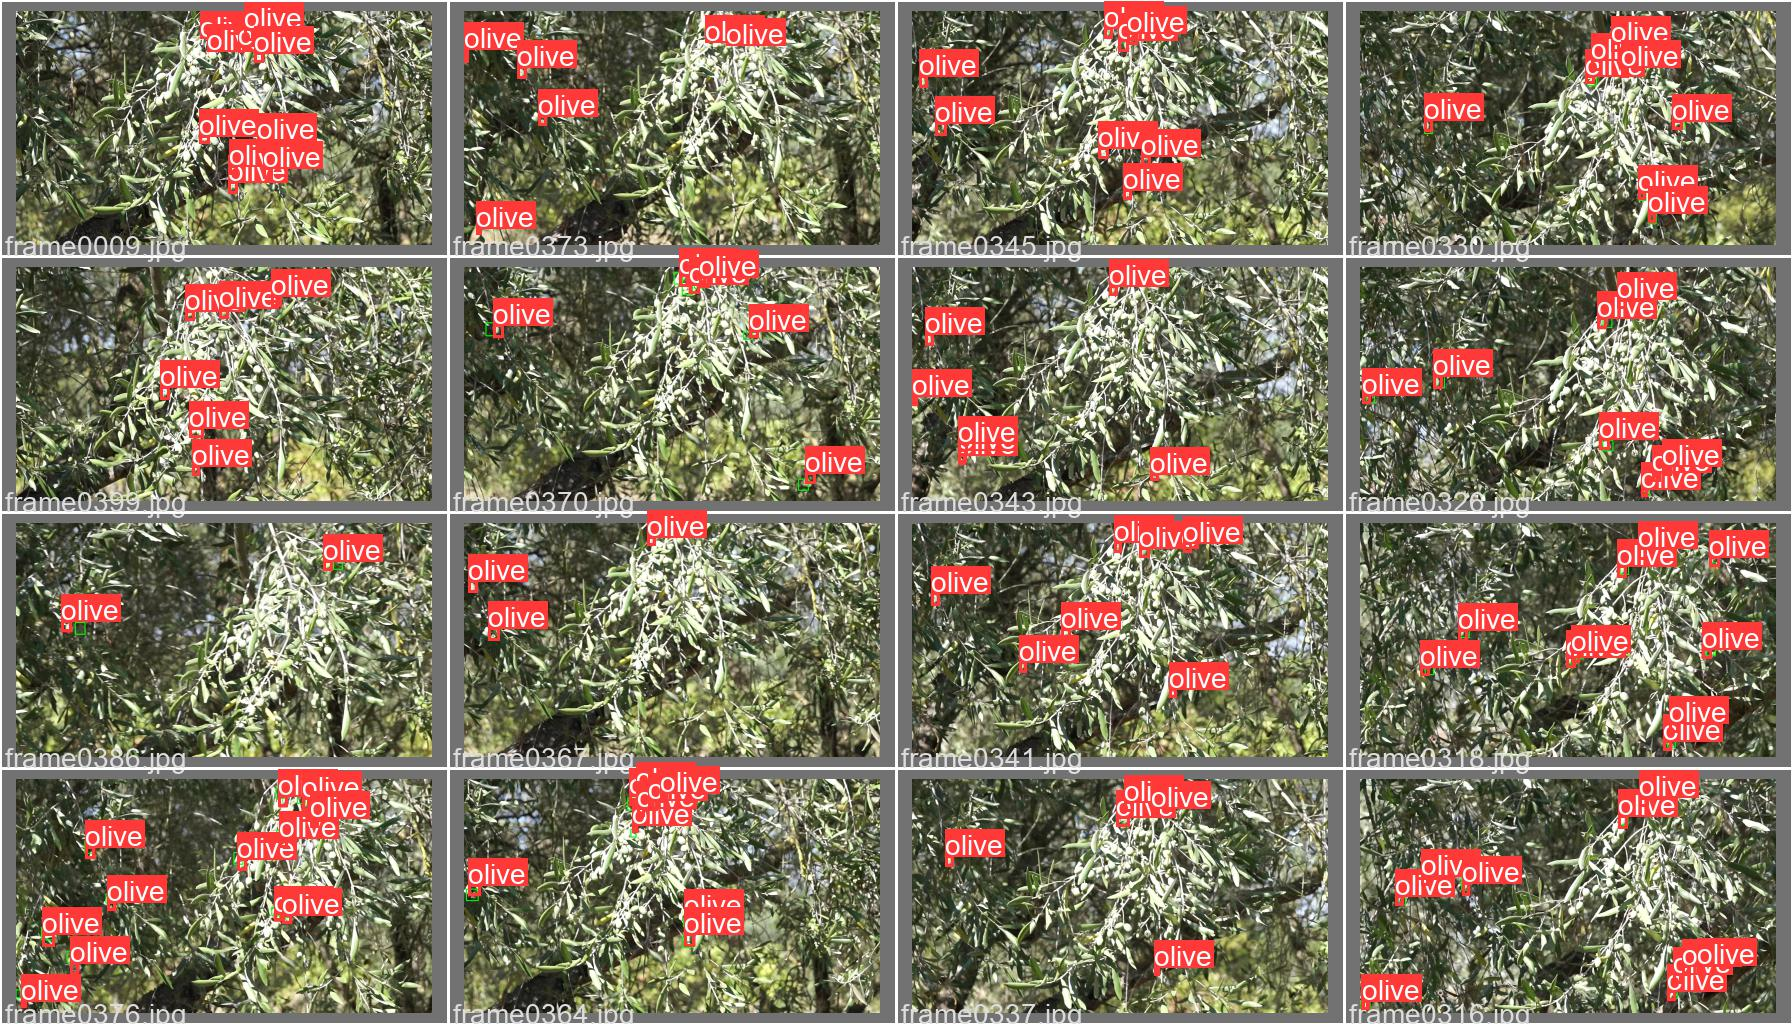

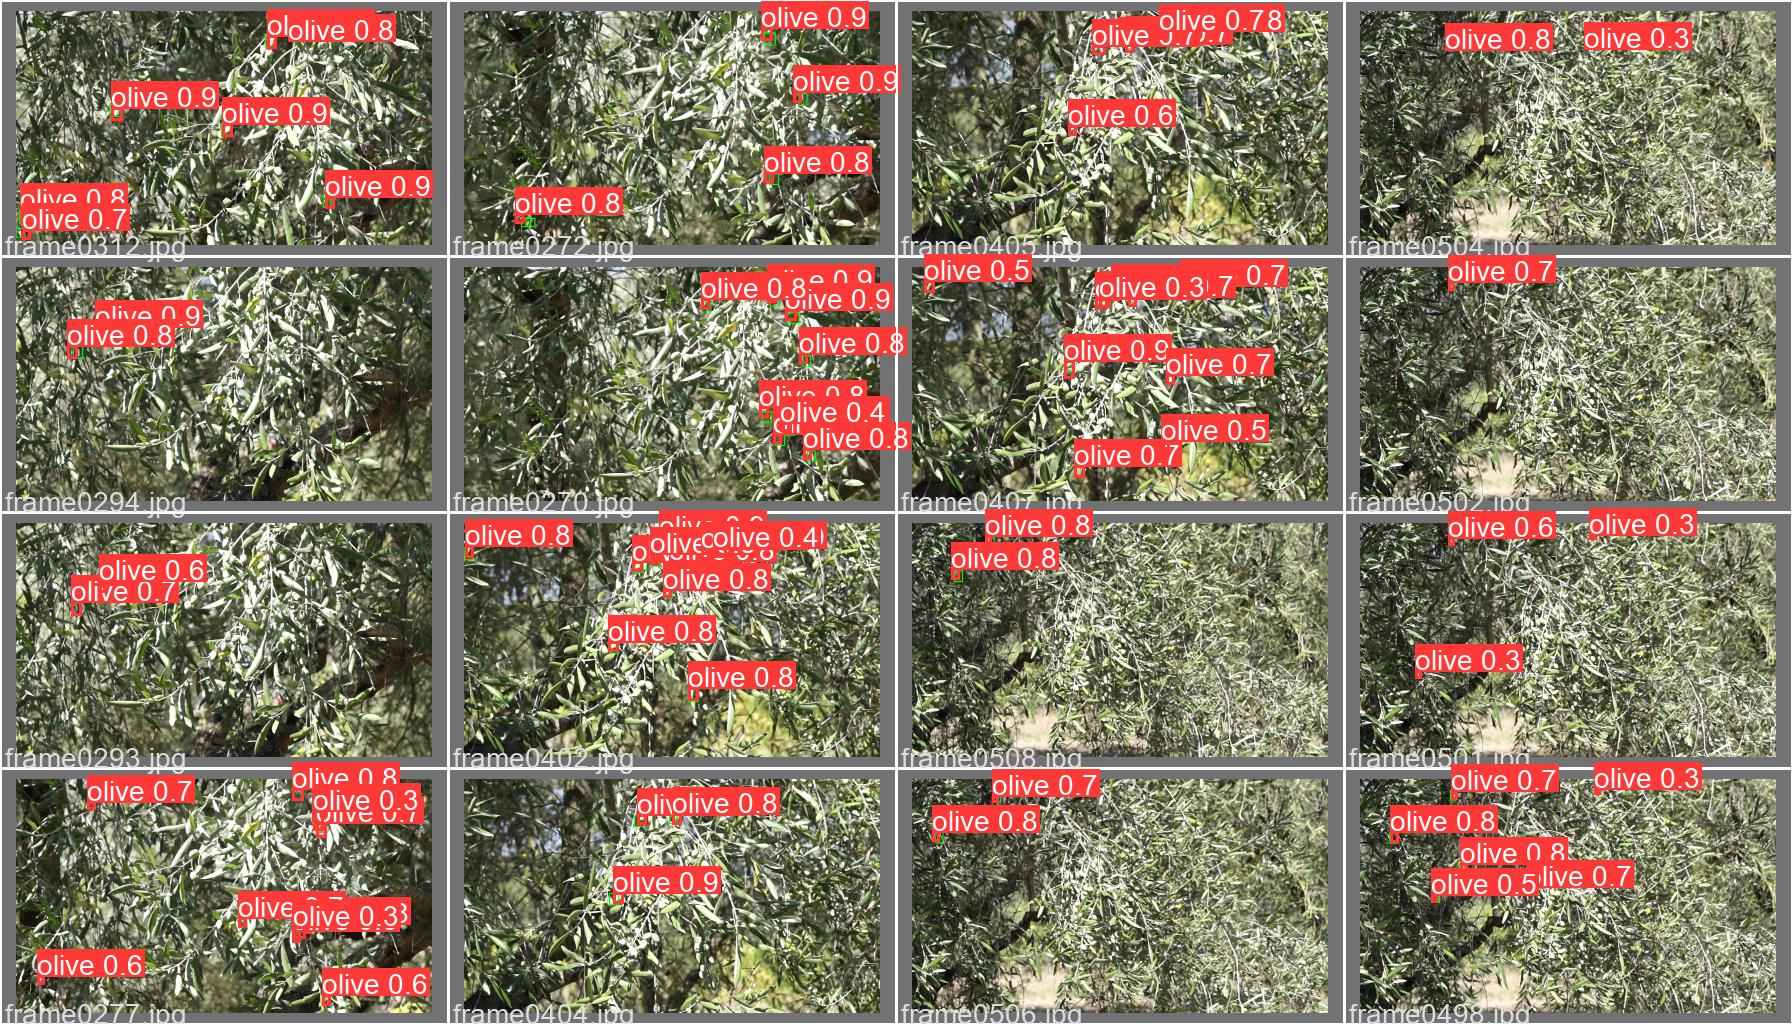

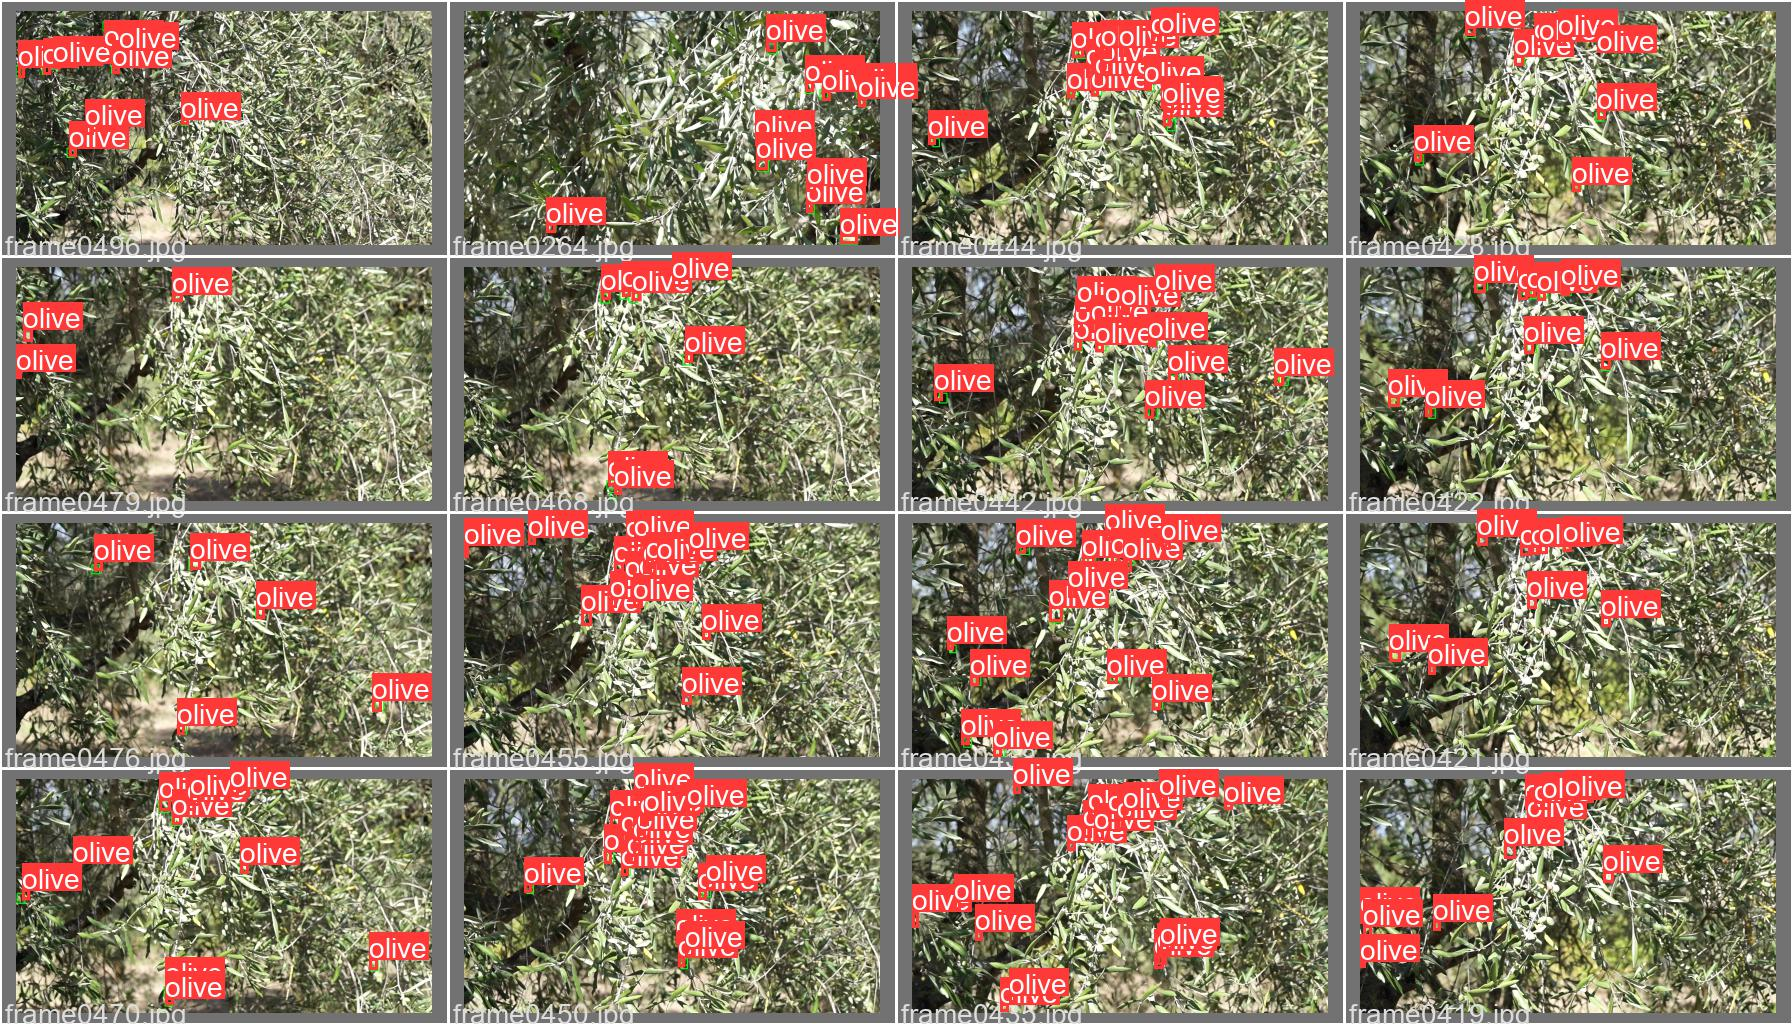

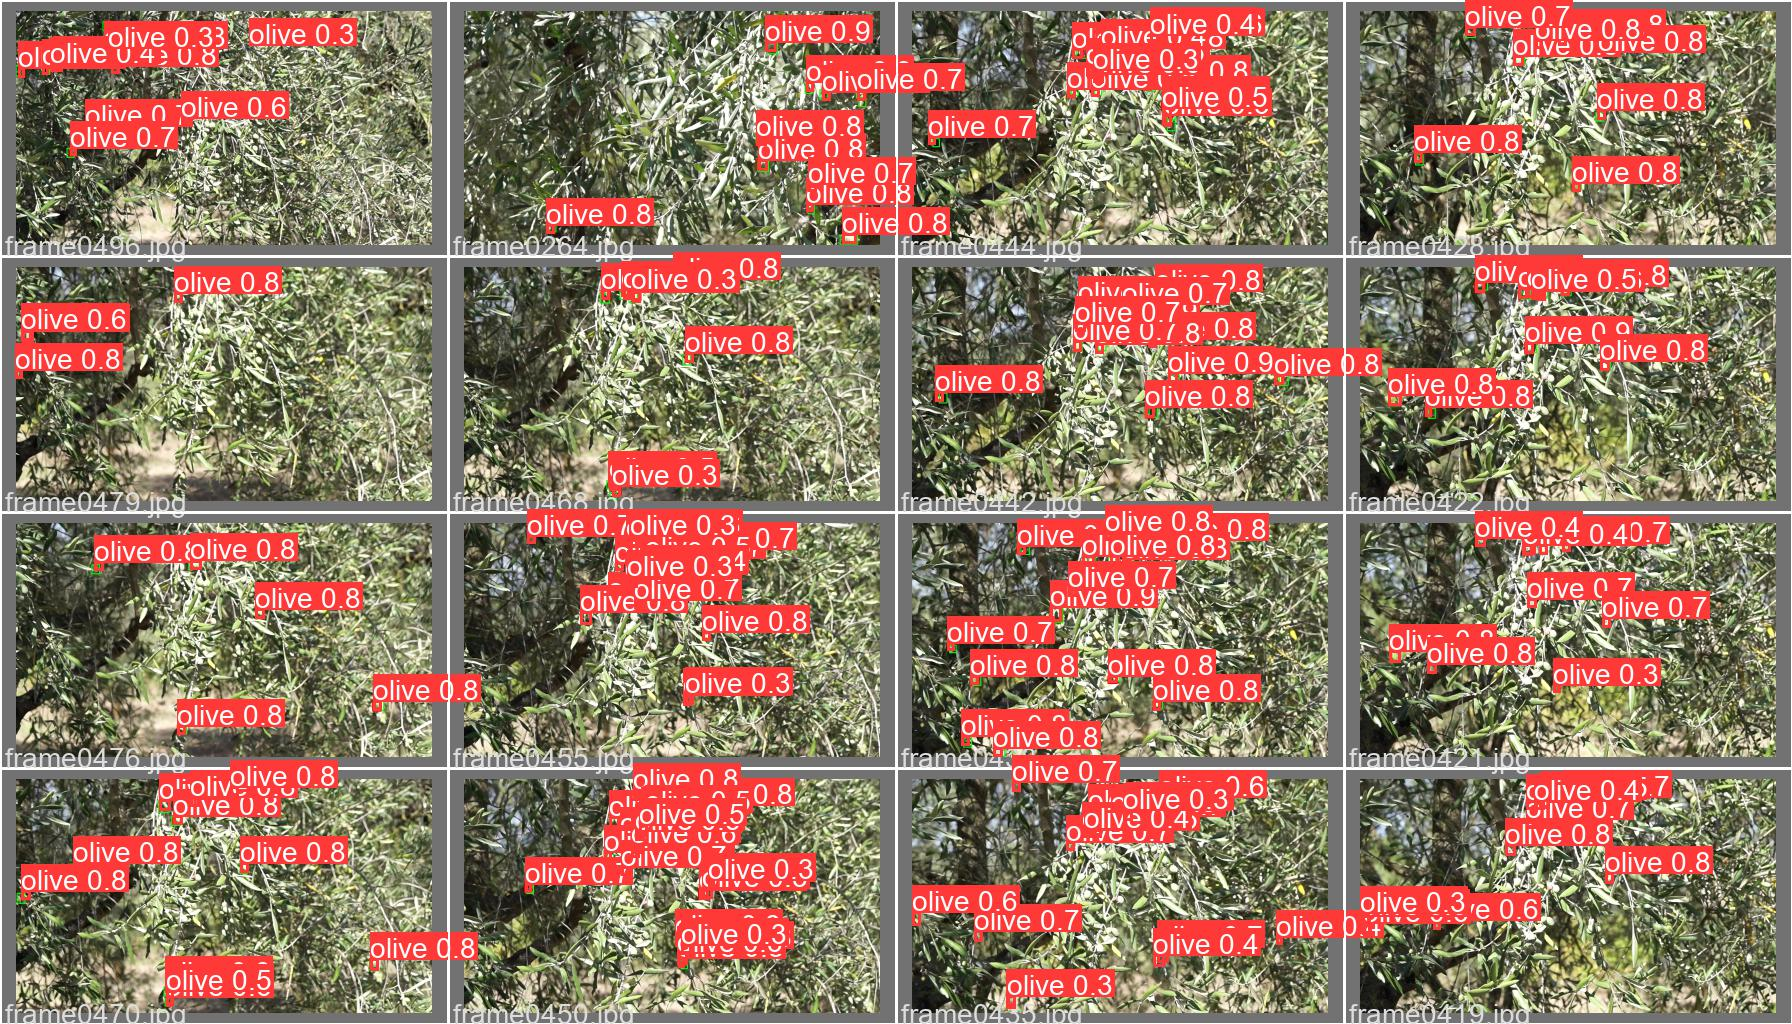

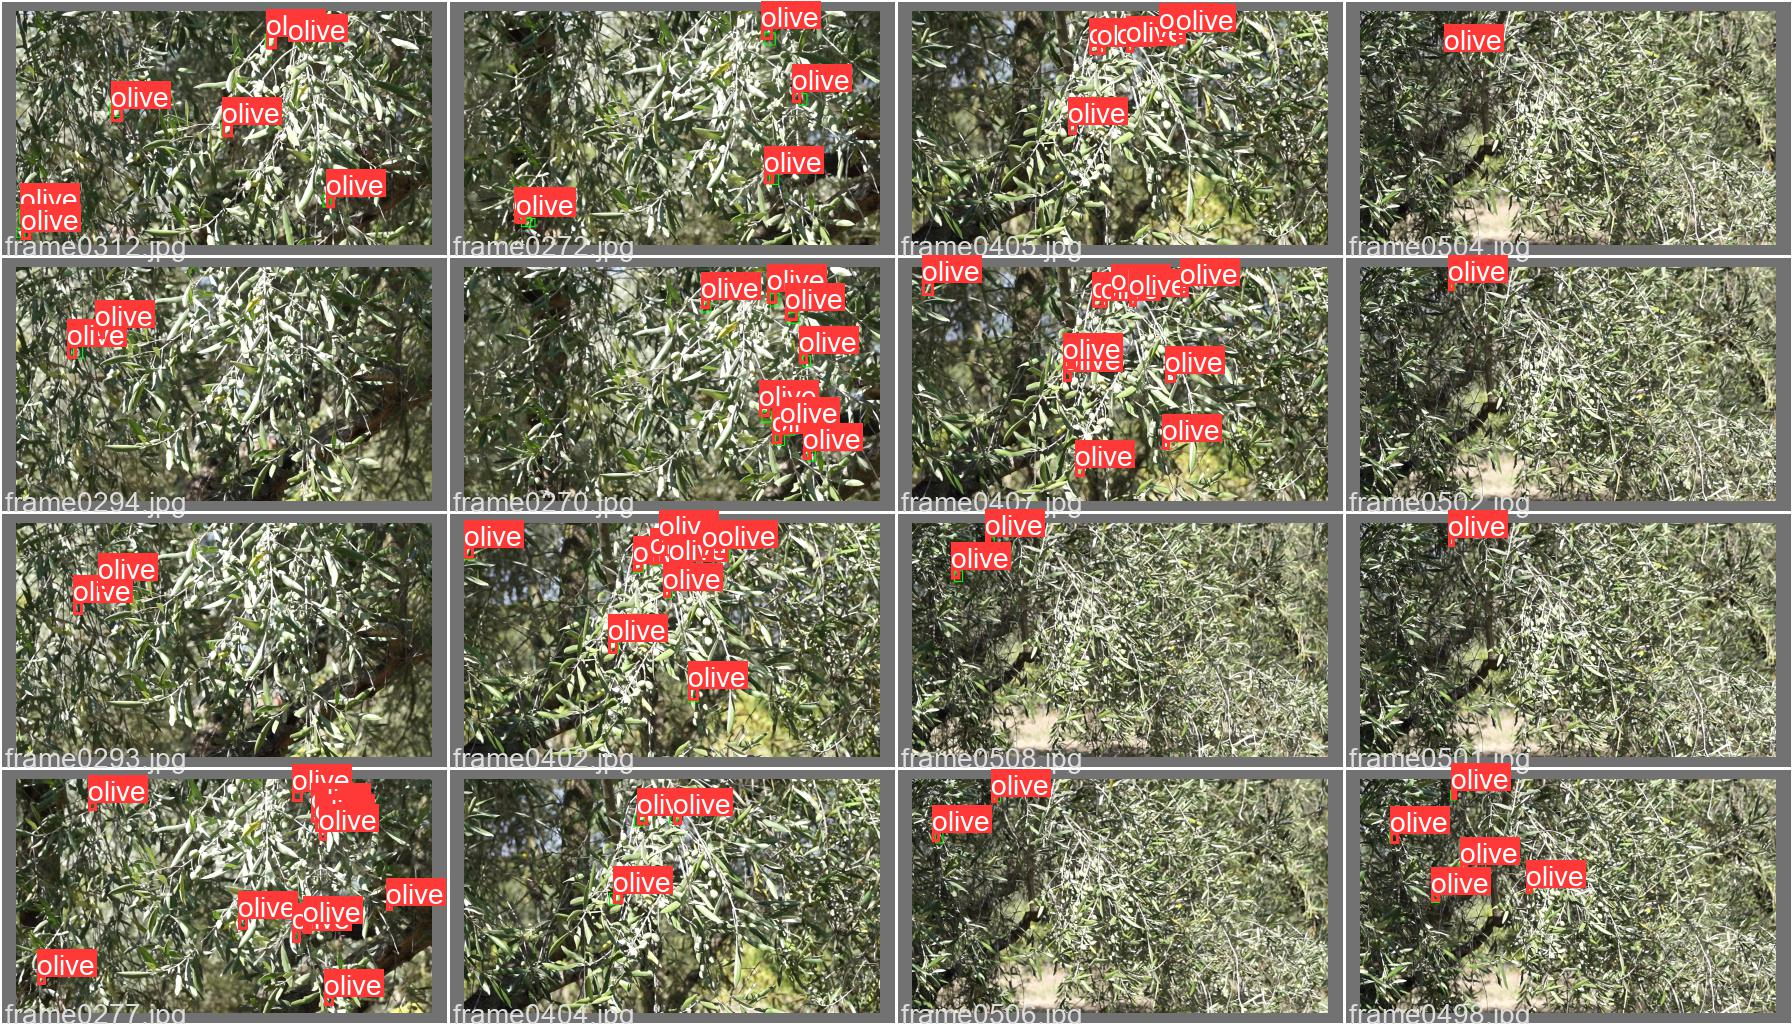

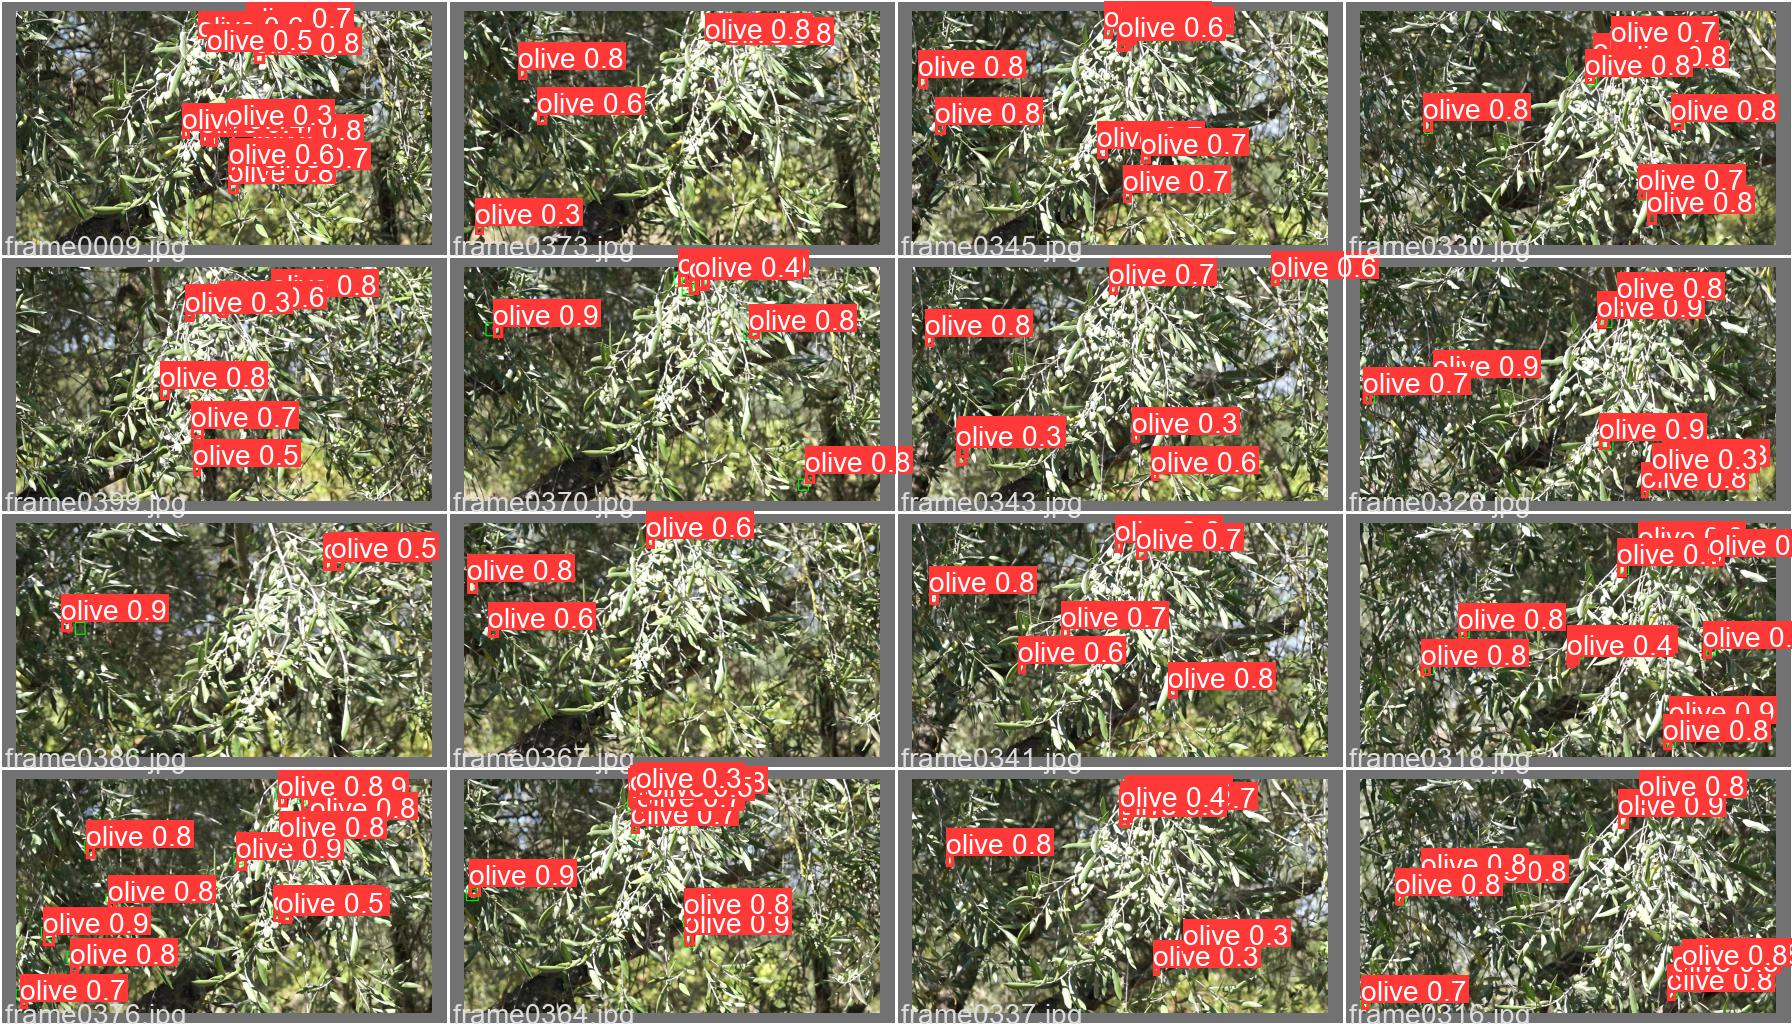

In [56]:

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/val/exp5/*.jpg'): #assuming JPG
    display(Image(filename=imageName,width=1280))
    print("\n")


In [ ]:
for imageName in glob.glob('/content/yolov5/runs/val/exp6/*.png'): #assuming JPG
    display(Image(filename=imageName,width=960))
    print("\n")

## **INFERENZA TARGET DETECTOR**

Infine faccio l'inferenza su un nuovo set di immagini creato estraendo i frame dal video2 che si trova al seguente path Olive_Detection_Tracking_dataset_video/videos 

In [ ]:
!python detect.py --source Olive_Detection_Tracking/dataset_video/frame_video/frame_video2 --data data/target_dataset.yaml --weights runs/train/exp/weights/best.pt --save-txt --conf-thres 0.40